In [163]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 294179385 Submission (EP:)

- not full original analysis, mainly to correct the identification in https://www.aavso.org/vsx/index.php?view=detail.top&oid=2216155


## TESS Data



In [164]:
tic = 294179385

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# get some sample data for visualization
# lcc_tess = of_sectors(sr, 41, 75).download_all()
lcc_tess = sr[sr.author == "SPOC"].download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 14,2019,QLP,1800,294179385,0.0,N/A
1,TESS Sector 15,2019,QLP,1800,294179385,0.0,N/A
2,TESS Sector 16,2019,QLP,1800,294179385,0.0,N/A
3,TESS Sector 41,2021,SPOC,120,294179385,0.0,"G04242 , G04039"
4,TESS Sector 54,2022,SPOC,120,294179385,0.0,"G04242 , G04039"
5,TESS Sector 55,2022,SPOC,120,294179385,0.0,"G04242 , G04039"
6,TESS Sector 56,2022,SPOC,120,294179385,0.0,N/A
7,TESS Sector 75,2024,SPOC,120,294179385,0.0,G06032
8,TESS Sector 76,2024,SPOC,120,294179385,0.0,G06032


LightCurveCollection of 6 objects:
    0: <TessLightCurve LABEL="TIC 294179385" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 294179385" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 294179385" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 294179385" SECTOR=56 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 294179385" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 294179385" SECTOR=76 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [165]:
# List of all TCEs of the TIC
display(HTML(lket.get_tic_meta_in_html(tic, download_dir=lk_download_dir)))

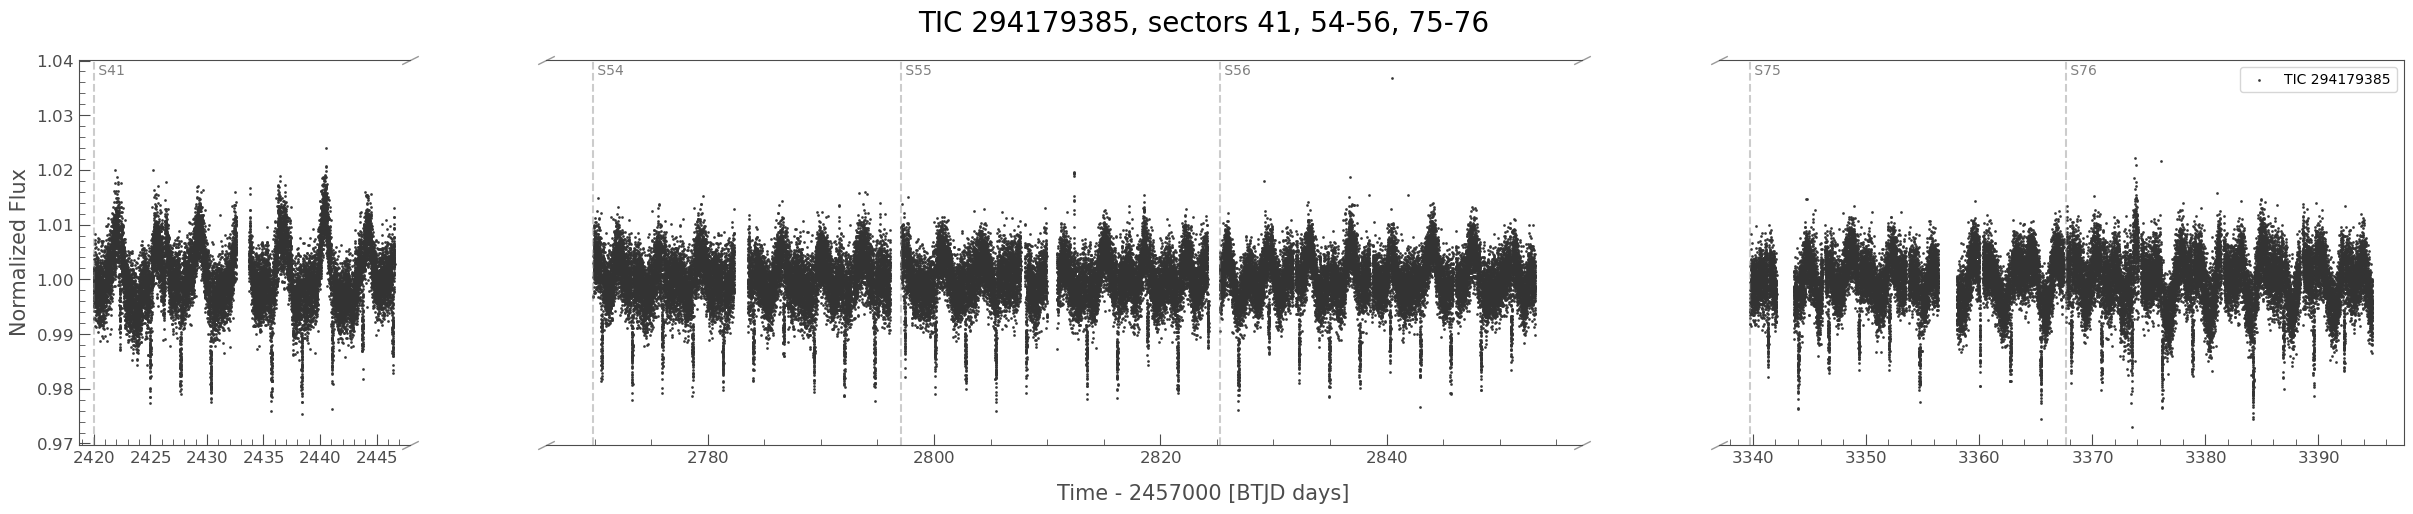

In [166]:
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,    
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);

---

## Gaia DR3 info (coordinate, etc.)

In [167]:
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


In [168]:
primary_name = "TOI-1454"  # follow SIMBAD

## Transit Parameters from existing sources

In [169]:
# From TOI 1454.01

period_initial = 2.67941 # rouded TOI value 2.679411 , based on their error 0.0000021
period_final = period_initial

epoch_time_btjd = 2770.6372
epoch_time_hjd = lke.to_hjd_utc(Time(epoch_time_btjd, format="btjd"), target_coord).value
epoch_time_hjd = round(epoch_time_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

duration_hr = 2.8360  

transit_depth_percent = 1.4060
transit_depth_mag = lke.ratio_to_mag(transit_depth_percent/100)
transit_depth_mag

0.01537378379751974

In [170]:
# Plots to visually verify the parameters

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,    )

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)

lc_combined_dict = dict(TESS=lc_tess)

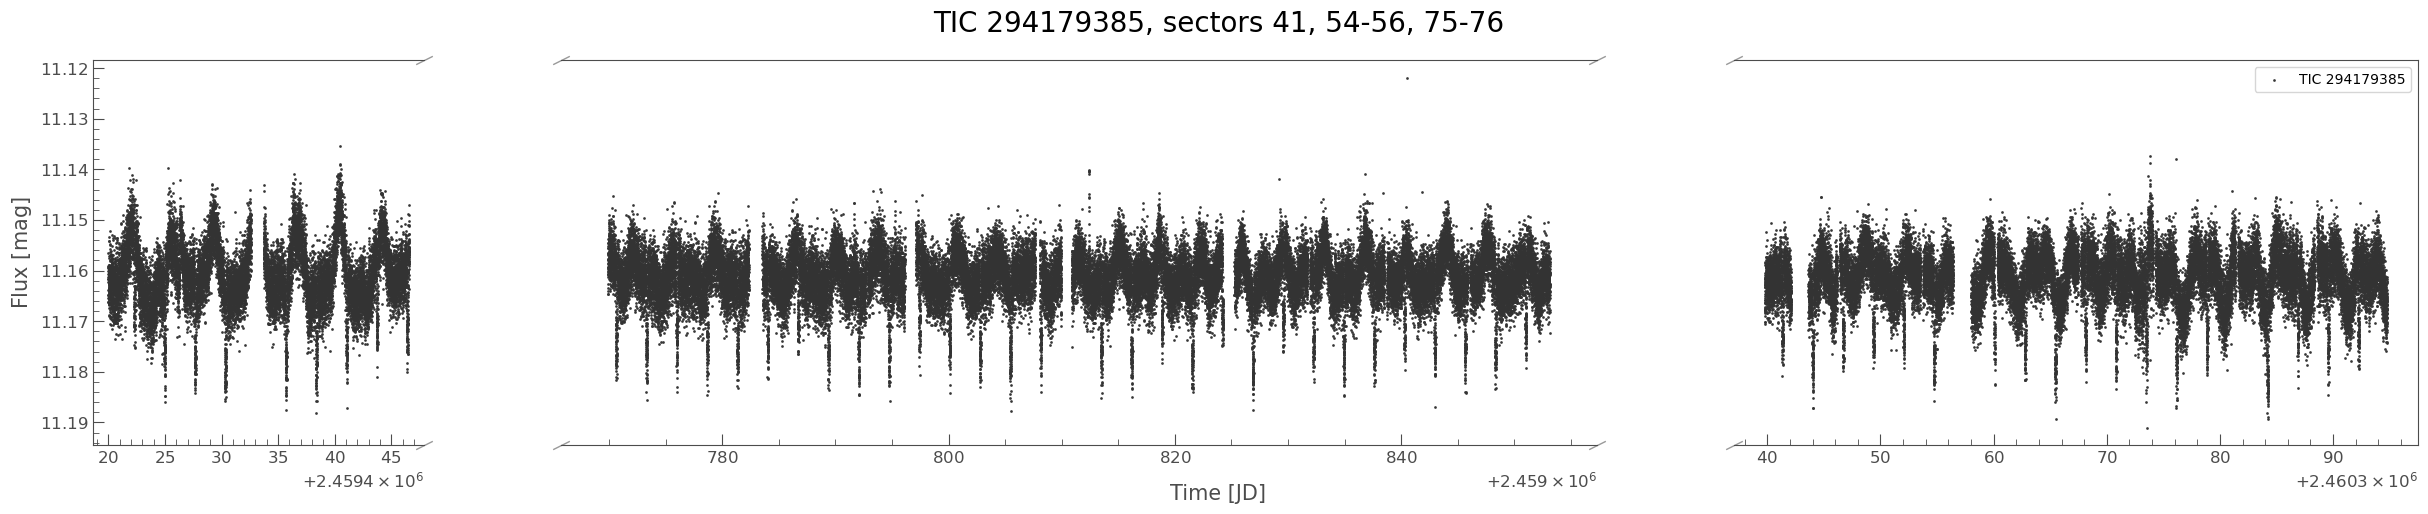

In [171]:
axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc_tess.label}, sectors {lke.abbrev_sector_list(lc_tess)}", fontsize=20);

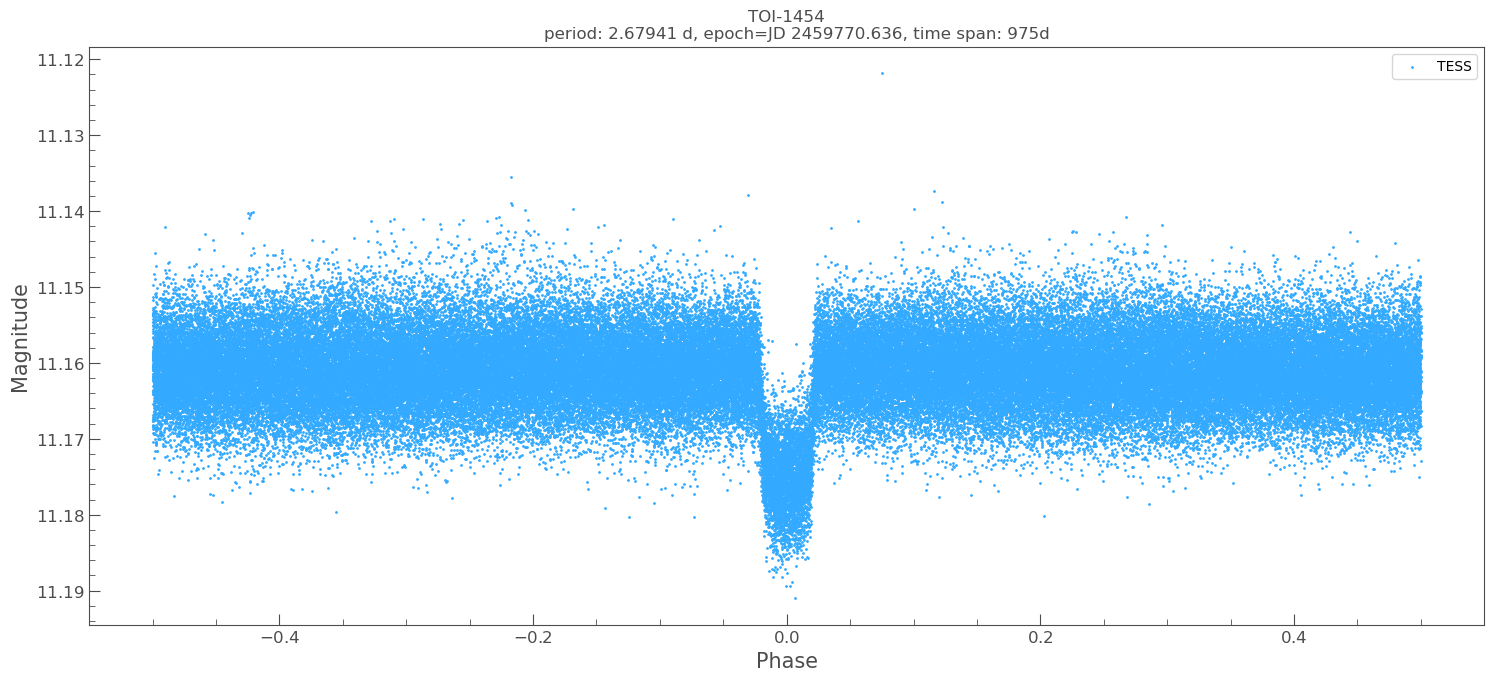

In [172]:
import lightkurve_ext_multi_sources as lkem

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) increase the marker size and move it to the front, to make TESS data more visible, its data is not rather sparse
plot_options[0][1]["s"] = 1  # default 0.1

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=1,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(18, 7.5),
    target_name=primary_name,
    plot_options=plot_options,
);
# ax.set_ylim(12.8, 11.9);
# ax.set_title(ax.get_title() + ", outliers truncated");

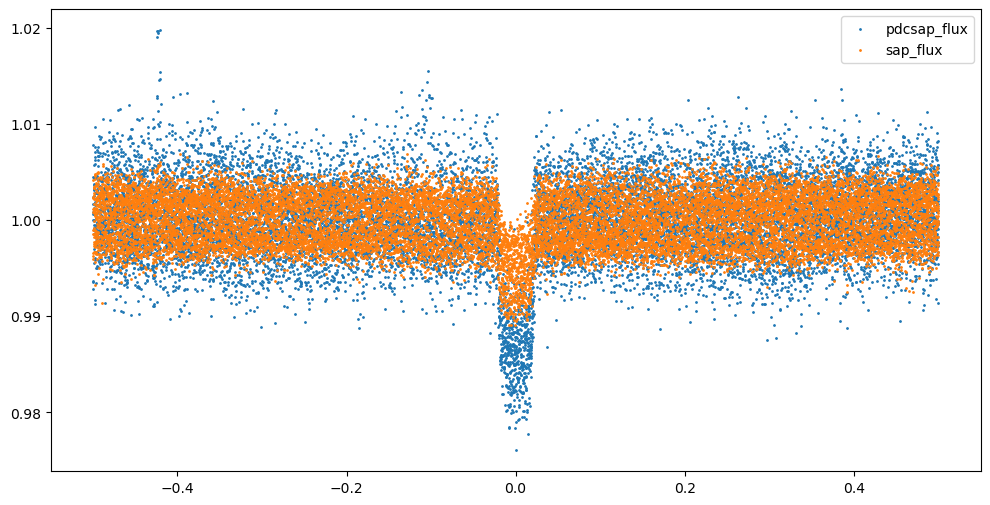

In [173]:
# Compare SAP_FLUX vs PDCSAP_FLUX with 1 sector sample (to avoid inconsistent normalization across sectors).
_lc_f = lc_f_res["TESS"].truncate(2798 + 2457000, 2822 + 2457000, column="time_original")
ax = plt.figure(figsize=(12, 6)).gca();
ax.scatter(_lc_f.time.value, _lc_f.pdcsap_flux.value / np.nanmedian(_lc_f.pdcsap_flux.value), s=1, label="pdcsap_flux");
ax.scatter(_lc_f.time.value, _lc_f.sap_flux.value / np.nanmedian(_lc_f.sap_flux.value), s=1, label="sap_flux");
ax.legend();

## Additional Variability

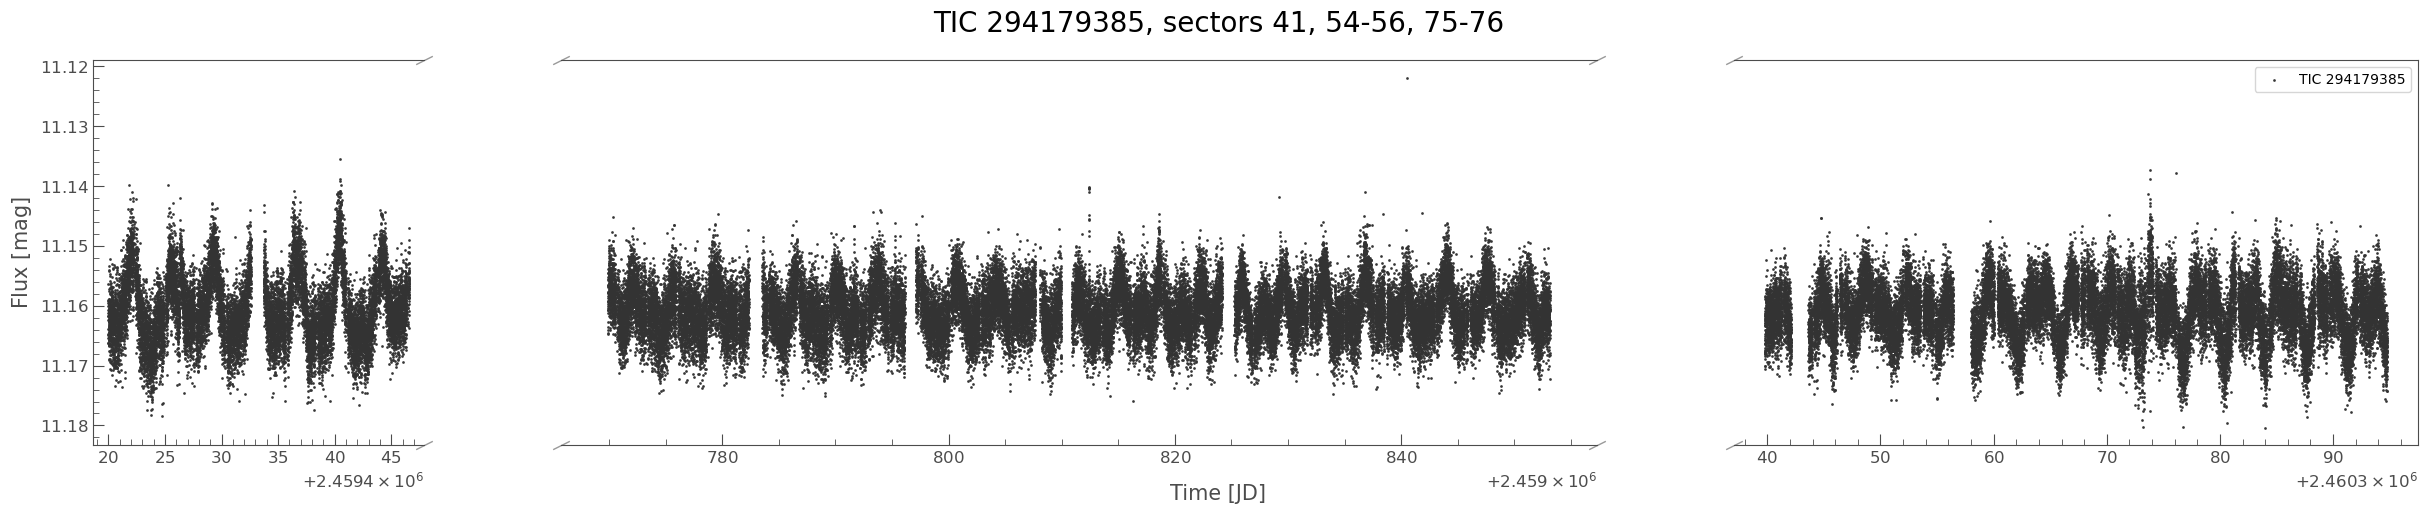

In [71]:
# mask the transit
tmask = lc_tess.create_transit_mask(period=period_final, transit_time=epoch_time_hjd, duration=duration_hr / 24 * 1.1)
lc_mag = lc_tess[~tmask]

axs = tplt.plot_skip_data_gap(lc_mag, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);

In [43]:
# for Period analysis, use normalize flux (to stick with the convention)
lc = lke.to_normalized_flux_from_mag(lc_mag)

In [44]:
pg = (
    lc
    .to_periodogram(method="lombscargle",
                     # maximum_period=9,
                       # minimum_period=10,                    
                       # minimum_period=0.0005, maximum_period=1,
                       # minimum_period=3, maximum_period=15,
                    # ls_method="fastchi2", nterms=2,
                    # oversample_factor=50,  # default: 5
                      )
     )
print(len(lc), lc.time.max() - lc.time.min(), lc.time.min(), lc.time.max(), )
pg.show_properties();

107826 974.7836638959125 2459419.99060568 2460394.7742695757
lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
              targetid                         294179385      
          default_view                         frequency      
                 label                     TIC 294179385      
             ls_method                              fast      
frequency_at_max_power                            0.2772 1 / d
             max_power                            0.0024      
               nyquist                          359.9977 1 / d
   period_at_max_power                            3.6076     d
             frequency                  array (1754599,) 1 / d
                period                  array (1754599,)     d
                 power                  array (1754599,)      
                  meta

In [49]:
# reload(lke_pg)
peaks = lke_pg.find_peaks(
    pg,
    # pg[pg.frequency > 100 * u.microhertz], 
    # powerlimit=0.0001,   
)
if "period" not in peaks.columns:
    peaks["period"] = 1 / peaks["frequency"]
    peaks["period"].unit = 1 / peaks["frequency"].unit
if "frequency" not in peaks.columns:
    peaks["frequency"] = 1 / peaks["period"]
    peaks["frequency"].unit = 1 / peaks["period"].unit
peaks["frequency_u"] = u.Quantity(peaks["frequency"]).to(u.microhertz)  # in microhertz, for log scale plot
peaks["period_h"] = u.Quantity(peaks["period"]).to(u.hour)  # period in hours
peaks["rank"] = np.linspace(1, len(peaks), len(peaks), dtype=int)

# peaks[peaks["frequency_u"] > 1000][:15]
# peaks[peaks["frequency_ratio"] < 5][:15]
peaks[peaks["period"] > 0][:15]

power,frequency,prominence,lower_hwhm,upper_hwhm,fwhm,frequency_ratio,period,frequency_u,period_h,rank
,1 / d,,1 / d,1 / d,1 / d,,d,uHz,h,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
0.00239665389392558,0.2771897088632909,0.0023922152366792557,-0.0005002,+0.00045052,0.00095072,1.000,3.607637542175842,3.208214222954756,86.5833010122202,1
0.0022294617227106373,0.2751379715660053,0.0020267375180334788,-0.00051642,+0.00033109,0.00084751,1.007,3.634540133840091,3.1844672634954314,87.22896321216218,2
0.002156535108642589,0.2825242258362336,0.0019516319168687384,-0.00051328,+0.0004315,0.00094477,0.981,3.5395194767462326,3.269956317549,84.94846744190959,3
0.0019452236674449858,0.5547897651860391,0.0019379641093513302,-0.00050698,+0.00054264,0.0010496,0.500,1.8024845856063467,6.421177837801379,43.25963005455232,4
0.001712463225571936,0.5527380278887534,0.001674092767793748,-0.00039515,+0.00080895,0.0012041,0.501,1.8091753227466822,6.397430878342053,43.42020774592037,5
0.0017114411216819707,0.2675465435660484,0.001588185074655093,-0.0003396,+0.00037418,0.00071378,1.036,3.7376674229137743,3.0966035134959307,89.70401814993059,6
0.001711066889126487,0.5494552482130963,0.0014919352439357698,-0.00047609,+0.00042744,0.00090353,0.504,1.8199844359520396,6.359435743207134,43.67962646284895,7
0.0017595534075025942,0.2698034545930626,0.0014668658043705883,-0.00045372,+0.00025131,0.00070503,1.027,3.706401763862785,3.1227251689011877,88.95364233270683,8


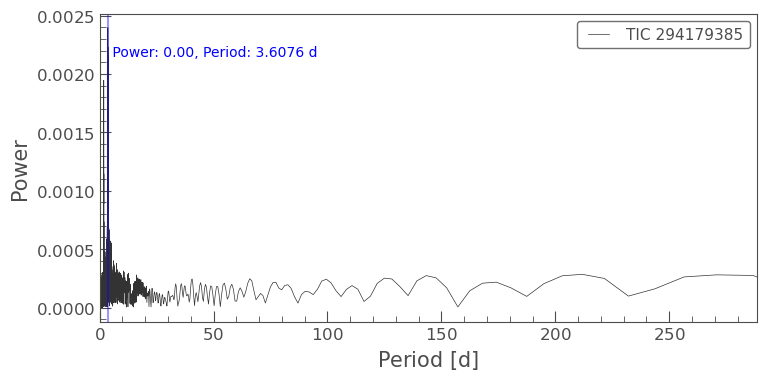

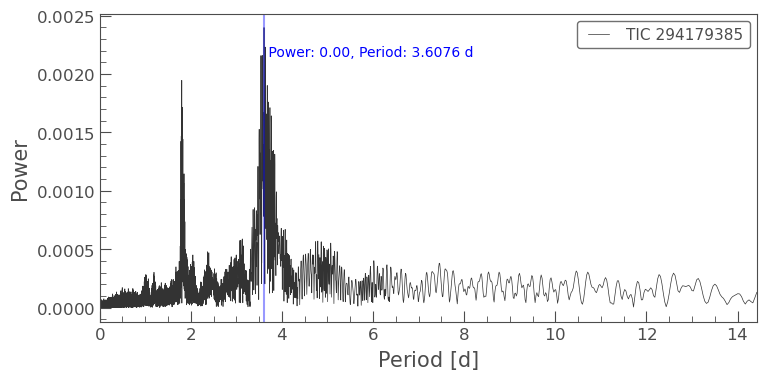

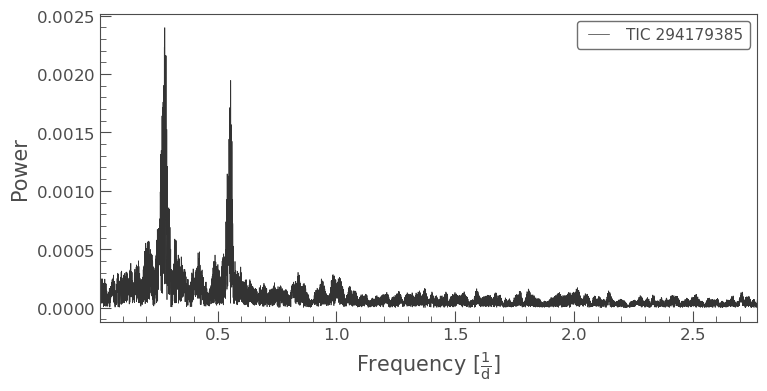

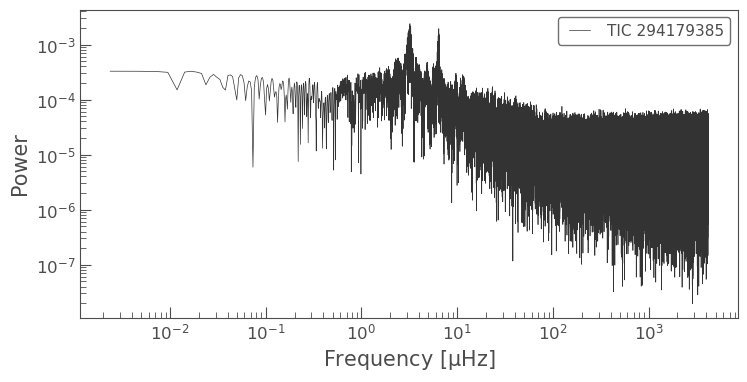

In [46]:
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=4);

# ---

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");  
# the smoothed plot is useful for repsresenting convective background (that scientists usually want to filter out)
# smooth_pg = pg.smo7oth(method='logmedian', filter_width=0.1)
# smooth_pg.plot(ax=ax, linewidth=2,  color='red', label='Smoothed (bkg)', unit=u.microhertz, scale='log');


plt.show(ax.get_figure())
display(HTML(""" <a href="https://docs.lightkurve.org/tutorials/3-science-examples/asteroseismology-oscillating-star-periodogram.html" target="_oscillator_lk_pg">Oscillator Periodogram from Lightkurve</a> """))

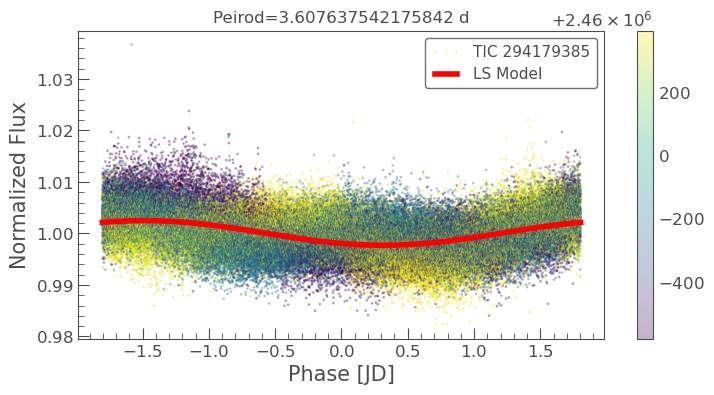

In [51]:
# reload(lke_pg)
axs, lcs = lke_pg.plot_lc_with_model(
    lc.normalize(),
    pg, 
    plot_lc=False, plot_model=False, plot_folded_model=True,
    # plot_folded_model_with_time_cmap=False,
    also_return_lcs=True);
    # [ax.set_ylim(0.991, 1.009) for ax in axs]
axs[-1].set_title(f"Peirod={pg.period_at_max_power}");
# axs[-1].set_ylim(0.96, None);

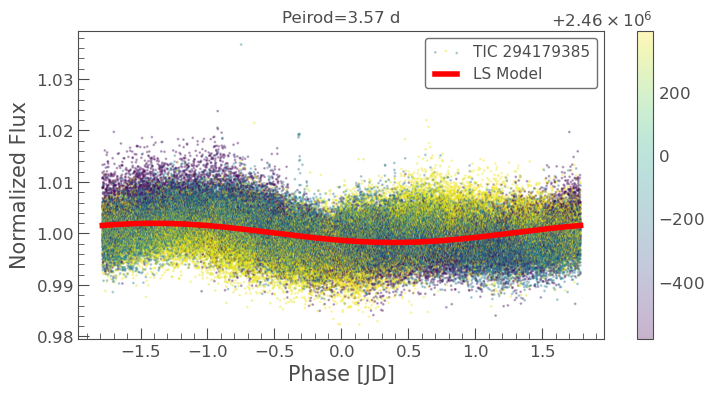

In [73]:
# reload(lke_pg)
axs, lcs = lke_pg.plot_lc_with_model(
    lc.normalize(),
    pg, 
    period=3.57* u.d,  # from 2023MNRAS.521.3749M
    plot_lc=False, plot_model=False, plot_folded_model=True,
    # plot_folded_model_with_time_cmap=False,
    also_return_lcs=True);
    # [ax.set_ylim(0.991, 1.009) for ax in axs]
axs[-1].set_title(f"Peirod=3.57 d");
# axs[-1].set_ylim(0.96, None);

### Identification of the time of some good looking (V-shaped) rotational minima

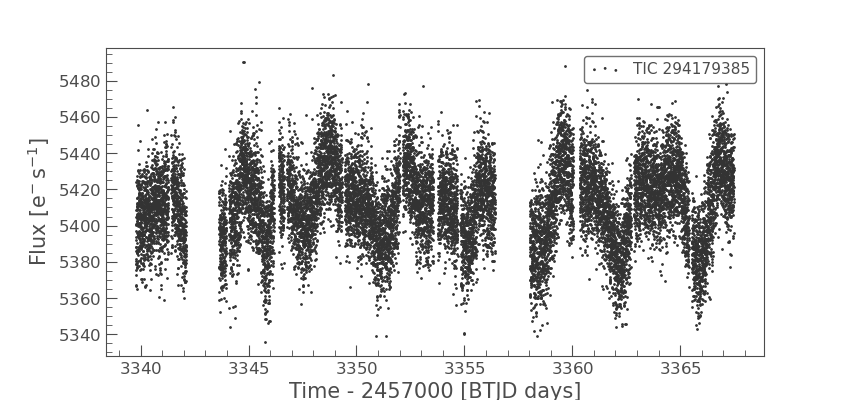

In [90]:
%matplotlib widget

lc75 = of_sector(lcc_tess, 75)
tmask75 = lc75.create_transit_mask(period=period_final, transit_time=epoch_time_btjd, duration=duration_hr / 24 * 1.1)
lc75 = lc75[~tmask75]
ax = lc75.scatter();


In [88]:
%matplotlib inline

pg75 = lc75.to_periodogram();
pg75.show_properties();

lightkurve.Periodogram properties:
      Attribute         Description      Units    
---------------------- -------------- ------------
                nterms              1             
              targetid      294179385             
          default_view      frequency             
                 label  TIC 294179385             
             ls_method           fast             
frequency_at_max_power         0.2672        1 / d
             max_power        13.5703 electron / s
               nyquist       360.0024        1 / d
   period_at_max_power         3.7428            d
             frequency array (49854,)        1 / d
                period array (49854,)            d
                 power array (49854,) electron / s
                  meta <class 'dict'>             


In [104]:
# manually find a good period based on a few observed minimum
for p in [3.6]: 
    print((3365.77 - 3345.85) /p,  (3365.77 - 3351.10) / p)

(3365.77 - 3351.10) / 4

5.533333333333354 4.07500000000002


3.667500000000018

[3347.5325, 3351.2, 3362.2025, 3365.87]

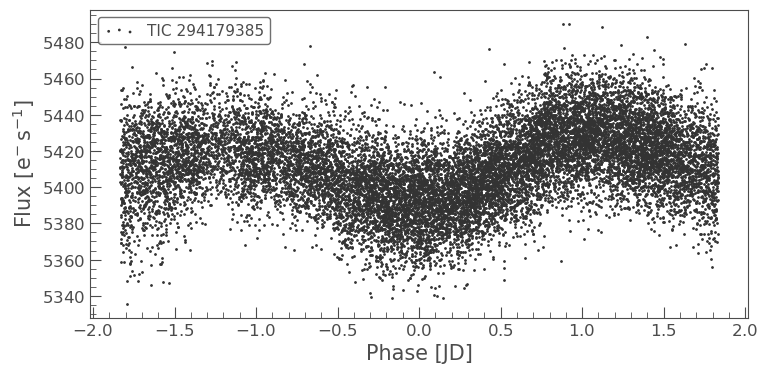

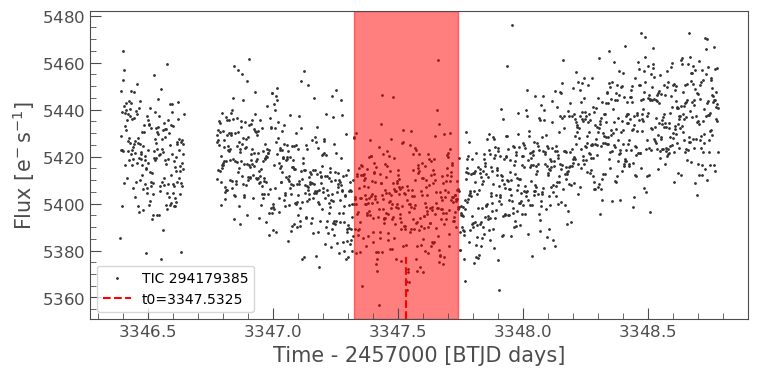

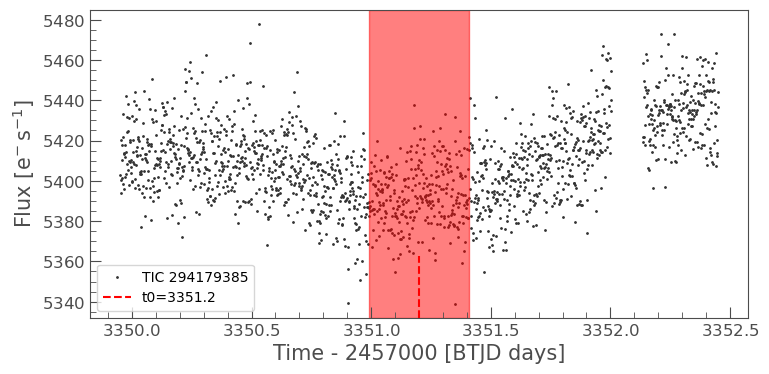

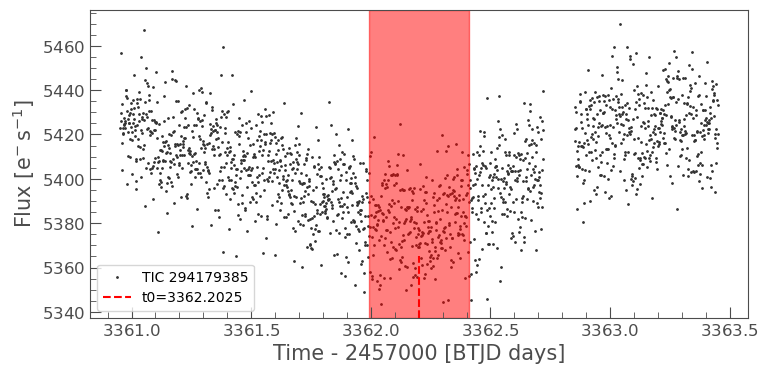

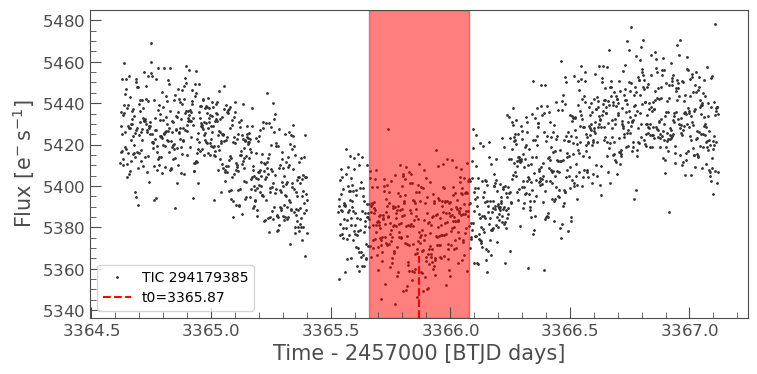

In [114]:
%matplotlib inline

# use

ax = lc75.fold(period=3.6675, epoch_time=3351.20).scatter();

t0_list = []
for i in [-1, 0, 3, 4 ]:  # cherry-pick those that look lkie a V-shaped dip  # range(-2, 5)
    half_width = 1.25
    t0 = 3351.20 + 3.6675 * i
    t0_list.append(t0)
    rot_min_duration_hr = 10
    ax = lc75.truncate(t0 - half_width, t0 + half_width).scatter();
    ax.axvspan(t0 - rot_min_duration_hr / 24 / 2, t0 + rot_min_duration_hr / 24 / 2, color="red", alpha=0.5);
    ax.axvline(t0, ymax=0.2, color="red", linestyle="--", label=f"t0={t0}")
    ax.legend();
t0_list

Centroid Identification of the above cherry-picked rotational minima 

using difference image based [TESS-Centroid_vetting](https://github.com/exo-pt/TESS-Centroid_vetting):

![img](https://i.gyazo.com/e0d7403eaaf9e7d016920d6f4121b0ba.png)


3.631999999999971

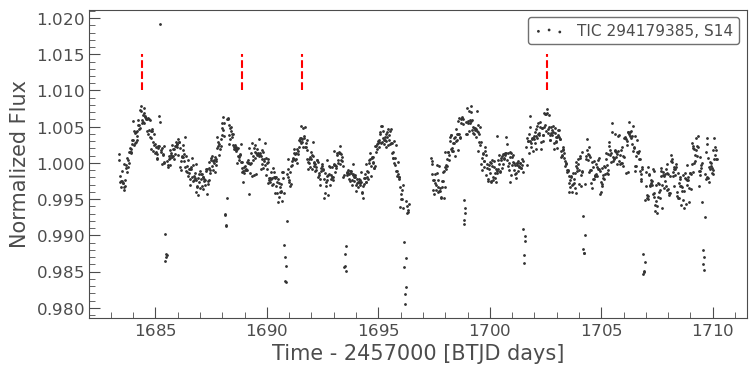

In [162]:
%matplotlib inline
# %matplotlib widget
    
lc14 = sr[0].download()  # QLP
lc14.label = lc14.label + f", S{lc14.sector}"
ax = lc14.scatter();
ax.vlines([1684.42, 1688.90, 1691.59, 1702.58], ymin=1.01,  ymax=1.015, colors="red", linestyle="--", label="some ROT max");
(1702.58 - 1684.42) / 5

## Plots for VSX

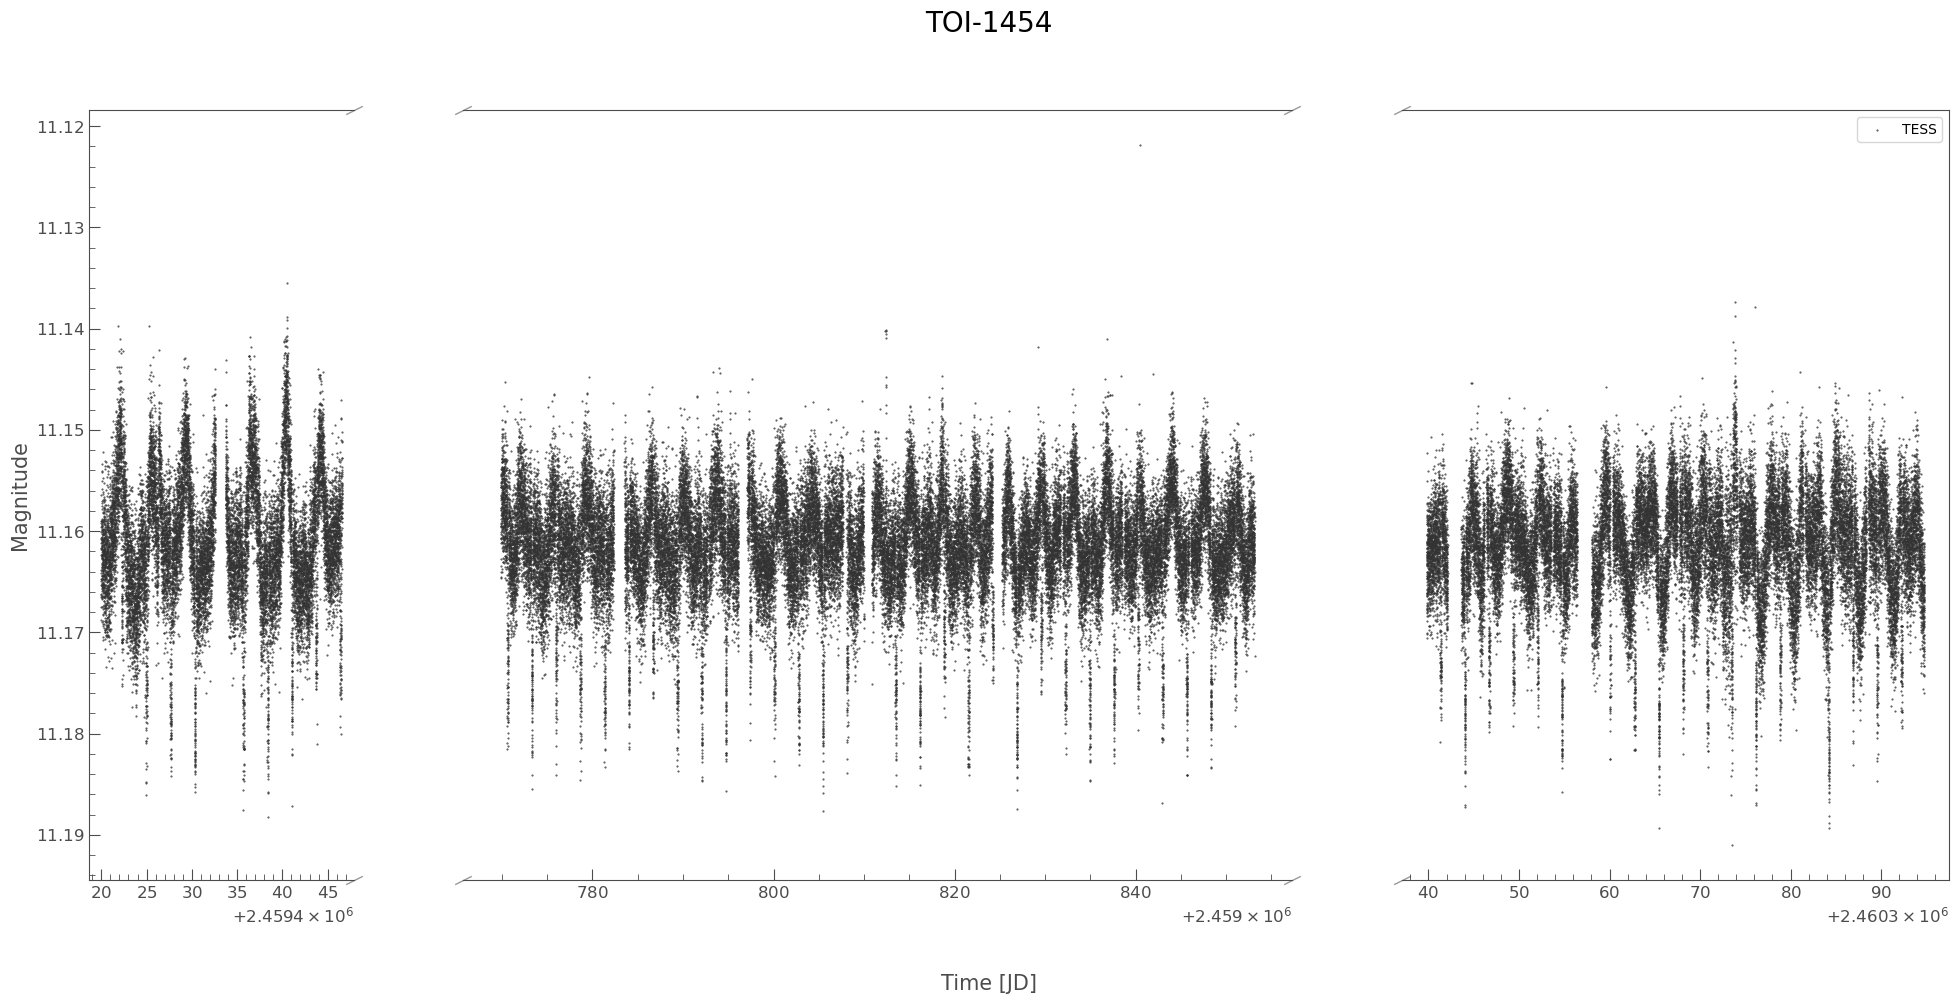

In [185]:
lc = lc_tess
lc.label = "TESS"
axs = tplt.plot_skip_data_gap(lc, figsize=(24, 10), s=1, alpha=0.9);
axs[0].set_ylabel("Magnitude");
axs[0].get_figure().suptitle(f"{primary_name}", fontsize=20);

## VSX Report Table

In [55]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [187]:
import bibs_utils
reload(bibs_utils)

other_names = f"TIC {tic}"  # include TIC, as TOI is the primary name
other_names += ",2MASS J20032213+5317392,UCAC4 717-067409"  # from TIC + SIMBAD
# GSC: not included. GSC 1.3 has 3 entries, both are a bit off betweent target and the contaminant TIC 294179389 / TYC 3936-1093-1
# https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6631480d21ff8e&-to=-4b&-from=-2&-this=-4&%2F%2Fsource=I%2F255&%2F%2Ftables=I%2F255%2Fout&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&-out.add=_r&%2F%2Foutaddvalue=default&-sort=_r&-order=I&-oc.form=sexa&-nav=cat%3AI%2F255%26tab%3A%7BI%2F255%2Fout%7D%26key%3Asource%3DI%2F255%26pos%3A300.84225285475%2C+53.29423896458%28+10+arcsec+J2000%29%26HTTPPRM%3A&-c=300.84225285475%2C+53.29423896458&-c.eq=J2000&-c.r=+10&-c.u=arcsec&-c.geom=r&-source=&-out.src=I%2F255%2Fout&-source=I%2F255%2Fout&-out=GSC&-out=RAJ2000&-out=DEJ2000&-out=PosErr&-out=Pmag&-out=e_Pmag&-out=n_Pmag&-out=Class&-out=Epoch&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=5&-bmark=GET

remarks = f"""The target is determined to be the source of planet transit-like variability from TCE (centroid offset analysis) and ExoFOP (photometric and spectroscopic observations). Transit amplitude: {transit_depth_mag:.3f} TESS."""
remarks += """ Rotational period: 3.57 d, amplitude: 0.03 TESS. Rotational variability could be from the nearby TIC 294179389, 9" to the NW."""
    
revision_comment = "Identification of transit like signals from TESS TCE and TESS ExoFOP. EP type, orbital period, epoch, transit duration, and amplitude from TESS ExoFOP (TOI). ROT type and period from 2023MNRAS.521.3749M . Total amplitude and ROT amplitude from TESS data. Mean magnitude derived from Gaia DR3. Spectral type and position from Gaia DR3."

BIBS = bibs_utils.BIBS

vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EP:+ROT",
    Spectral_Type="G",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{11.707:.2f}",  # Gaia DR3 Gmag converted to V , the existing Vmag on SIMBAD (UCAC4-based) is too high 10.893
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=0.04,  # total amplitude in PDCSAP_FLUX plot. f"{transit_depth_mag:.3f}",
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=True,
    Period=period_final,
    Epoch=epoch_time_hjd,
    Rise_Duration_Pct=f"{100 * duration_hr / 24 / period_final:.0f}",
    Discoverer="TESS Follow-up Observing Program Working Group",  
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference1_Name=BIBS.TCE_N(2023),   # The sector 14-60 TCE generated on Feb 2023
    Reference1_Link="https://exo.mast.stsci.edu/exomast_planet.html?planet=TOI1454.01",  # Point to Sector 14-60 TCE
    Reference2_Name="TESS Exoplanet Follow-up Observing Program (ExoFOP) (online data)", 
    Reference2_Link="https://exofop.ipac.caltech.edu/tess/target.php?id=294179385",
    Reference3_Name="Magliano, C.; et al., 2023,  The TESS Triple-9 Catalog II: a new set of 999 uniformly vetted exoplanet candidates", 
    Reference3_Bib="2023MNRAS.521.3749M",
    Reference4_Name=BIBS.TESS_N,
    Reference4_Bib=BIBS.TESS_B,

)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

# Uploaded plots with  descriptions (nothing)
print("""
tic294179385_pdcsap_plot.png: Light curve - Light curve from TESS data.
""")


Other Names (1 line each):
TIC 294179385
2MASS J20032213+5317392
UCAC4 717-067409

The target is determined to be the source of planet transit-like variability from TCE (centroid offset analysis) and ExoFOP (photometric and spectroscopic observations). Transit amplitude: 0.015 TESS. Rotational period: 3.57 d, amplitude: 0.03 TESS. Rotational variability could be from the nearby TIC 294179389, 9" to the NW.

Identification of transit like signals from TESS TCE and TESS ExoFOP. EP type, orbital period, epoch, transit duration, and amplitude from TESS ExoFOP (TOI). ROT type and period from 2023MNRAS.521.3749M . Total amplitude and ROT amplitude from TESS data. Mean magnitude derived from Gaia DR3. Spectral type and position from Gaia DR3.


,Field,Value
0,Position,"300.84225285475, 53.29423896458"
1,Primary_Name,TOI-1454
2,Other_Names,"TIC 294179385,2MASS J20032213+5317392,UCAC4 717-067409"
3,Variable_Type,EP:+ROT
4,Spectral_Type,G
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,11.71
7,Maximum_Magnitude_band,V
8,Minimum_Magnitude,0.04
9,Minimum_Magnitude_band,TESS



tic294179385_pdcsap_plot.png: Light curve - Light curve from TESS data.



# Scratch